In [1]:
import numpy as np
import pandas as pd
from sklearn import mixture
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
log_summed_psd_by_connection = np.load('C:/Users/trevo/OneDrive/Allen/important_folders/analysis/assembly and centrality/hebbs_hypotheses/data_files/log10_connection_weigts_pyramidal_rect.npy')

In [40]:
def perform_standard_em(x, K, seed, weights_init=None, means_init=None, precisions_init=None):
    """Estimate GMM's parameters by using the standard EM algorithm, using kmeans clustering as an initialization.

    Args:
        x (2D numpy array): The observed data.
        K (int): The number of mixture component.
        seed (int): The random seed.

    Returns:
        results (dictionary): The dictionary containing estimated parameters.
    """

    x = pd.DataFrame(x)
    model = mixture.GaussianMixture(n_components=K, random_state=seed, covariance_type='diag', weights_init=weights_init, means_init=means_init, precisions_init=precisions_init)
    model.fit(x)

    std = np.sqrt(model.covariances_)

    results = {
        'pp': model.weights_,
        'mu': model.means_,
        'std': std
    }

    return results

def gmm_pdf_cdf(x, weights, means, std_devs):
    """
    Compute the PDF and CDF for a Gaussian Mixture Model (GMM).

    Parameters:
        x (np.ndarray): Points at which to evaluate the PDF and CDF.
        means (list): Means of the Gaussian components.
        stds (list): Standard deviations of the Gaussian components.
        weights (list): Weights of the Gaussian components.

    Returns:
        pdf (np.ndarray): PDF values for the GMM.
        cdf (np.ndarray): CDF values for the GMM.
    """
    pdf = np.zeros_like(x)
    cdf = np.zeros_like(x)
    for weight, mean, std_dev in zip(weights, means, std_devs):
        pdf += weight * norm.pdf(x, mean, std_dev)
        cdf += weight * norm.cdf(x, mean, std_dev)
    return pdf, cdf

def gmm_ppf(q, x, weights, means, std_devs):
    """
    Compute the PPF (percent-point function) for a Gaussian Mixture Model (GMM).

    Parameters:
        q (np.ndarray): Quantiles at which to compute the PPF.
        x (np.ndarray): Points used to evaluate the CDF.
        means (list): Means of the Gaussian components.
        stds (list): Standard deviations of the Gaussian components.
        weights (list): Weights of the Gaussian components.

    Returns:
        ppf (np.ndarray): PPF values for the GMM.
    """
    cdf_vals = gmm_pdf_cdf(x, weights, means, std_devs)[1]
    cdf_func = interp1d(cdf_vals, x, bounds_error=False, fill_value=(x[0], x[-1]))
    return cdf_func(q)

def hist_with_GMM_fit_plus_qqplot(PSD, means, std_devs, weights):
    """
    Plots a histogram of the provided data along with a Gaussian Mixture Model (GMM) fit,
    and generates a QQ plot comparing the empirical and theoretical quantiles.

    Parameters:
    PSD (np.ndarray): An array of data values (e.g., log10(PSD) values) to be plotted and fitted with the GMM.
    means (np.ndarray): The means of the Gaussian components in the GMM.
    std_devs(np.ndarray): The standard deviations of the Gaussian components in the GMM.
    weights(np.ndarray): The weights of the Gaussian components in the GMM.

    """
    # initialize plots
    fig, (hist, qq) = plt.subplots(1, 2, figsize=(10, 5))

    # get x range
    xmin, xmax = np.min(PSD), np.max(PSD)
    x_range = np.linspace(xmin, xmax, 100)

    # fit GMM 
    pdf, cdf = gmm_pdf_cdf(x_range, weights, means, std_devs)
    # histogram with fit overlaid
    hist.hist(PSD, bins='auto', density=True, alpha=0.5, color='purple')
    hist.plot(x_range, pdf, color="gold", alpha=0.5)
    hist.set_title("Histogram of log10PSD with GMM Fit Overlaid")
    hist.set_xlabel("Log10(PSD)")
    hist.set_ylabel("Density")
    
    # Generate Quantiles of Empirical, Theoretical Distributions

    empirical_quantiles = np.percentile(PSD, np.linspace(0, 100, len(PSD)))
    theoretical_quantiles = gmm_ppf(np.linspace(0, 1, len(PSD)), x_range, weights, means, std_devs)

    # Manually Plot QQplot Comparing the Percentile 
    qq.plot(theoretical_quantiles, empirical_quantiles, 'o', color="purple", markersize=3, label='Quantiles')
    qq.plot([min(theoretical_quantiles), max(theoretical_quantiles)], 
             [min(theoretical_quantiles), max(theoretical_quantiles)], 'g--', label='Y=X')
    qq.set_xlabel('Theoretical Quantiles')
    qq.set_ylabel('Empirical Quantiles')
    qq.set_title('QQ Plot')

    plt.tight_layout()
    plt.show()

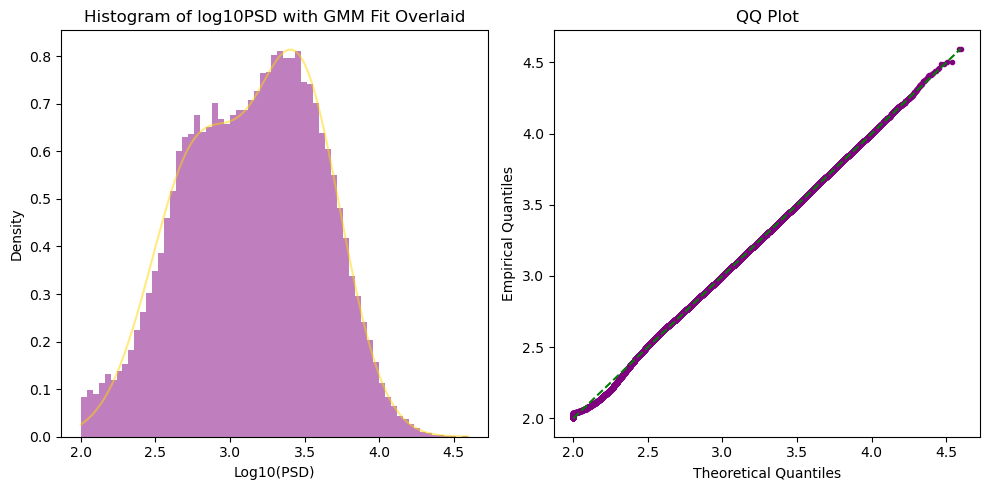

{'pp': array([0.45721871, 0.54278129]), 'mu': array([[2.77648218],
       [3.46002433]]), 'std': array([[0.31012149],
       [0.28779074]])}
Weighted Average: [3.14749607]


In [52]:
component_params = perform_standard_em(log_summed_psd_by_connection, K=2, seed=828)

hist_with_GMM_fit_plus_qqplot(log_summed_psd_by_connection, component_params['mu'], component_params['std'], component_params['pp'] )
print(component_params)
print('Weighted Average:', (component_params['mu'][0] * component_params['pp'][0]) + (component_params['mu'][1] * component_params['pp'][1]))

In [ ]:
{'pp': array([0.45721871, 0.54278129]), 'mu': array([[2.77648218],
       [3.46002433]]), 'std': array([[0.31012149],
       [0.28779074]])}
Weighted Average: [3.14749607]